In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [8]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [25]:
k_space = range(0.0, -0.5, step = -0.04)
length(k_space)

13

In [26]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [27]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [28]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                        Ttr = tspan[2] / 2, Δt = 0.1,
                                        diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
    
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    """Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)"""
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
index: 1
k: 0.0
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.0, 0.0]
Spectrum: [0.00014660322154511974, 0.00014660322154522252, -0.014952044690841474, -0.014952044690842423, -8.722418242098126, -8.722418242098126]
Last point: [-1.06443064005911, -4.474097515896169, 4.149001594303559, -1.06443064005911, -4.474097515896169, 4.149001594303559]
x_sum before truncate length: 3000001
x_sum after truncate length: 1500002
>>>>>>>>>>>>>>>

Initial condition: [-1.06443064005911, -4.474097515896169, 4.149001594303559, -1.06443064005911, -4.474097515896169, 4.149001594303559]
index: 2
k: -0.04
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.04, 0.0]
Spectrum: [0.010790462053719236, 0.010695616756398437, -6.635549268900504e-5, -0.01384026313693175, -8.76629368520977, -8.772621916395364]
Last point: [-1.2163441546313958, -6.503042344207349, 3.724621821296314, -1.2163441546313958, -6.503042344207349, 3.724621821296314]


In [29]:
using CairoMakie

In [30]:
CairoMakie.activate!()

In [31]:
using JLD

In [123]:
# save("spectrum_k1_k2_L2.jld", "data", spectrum_array)

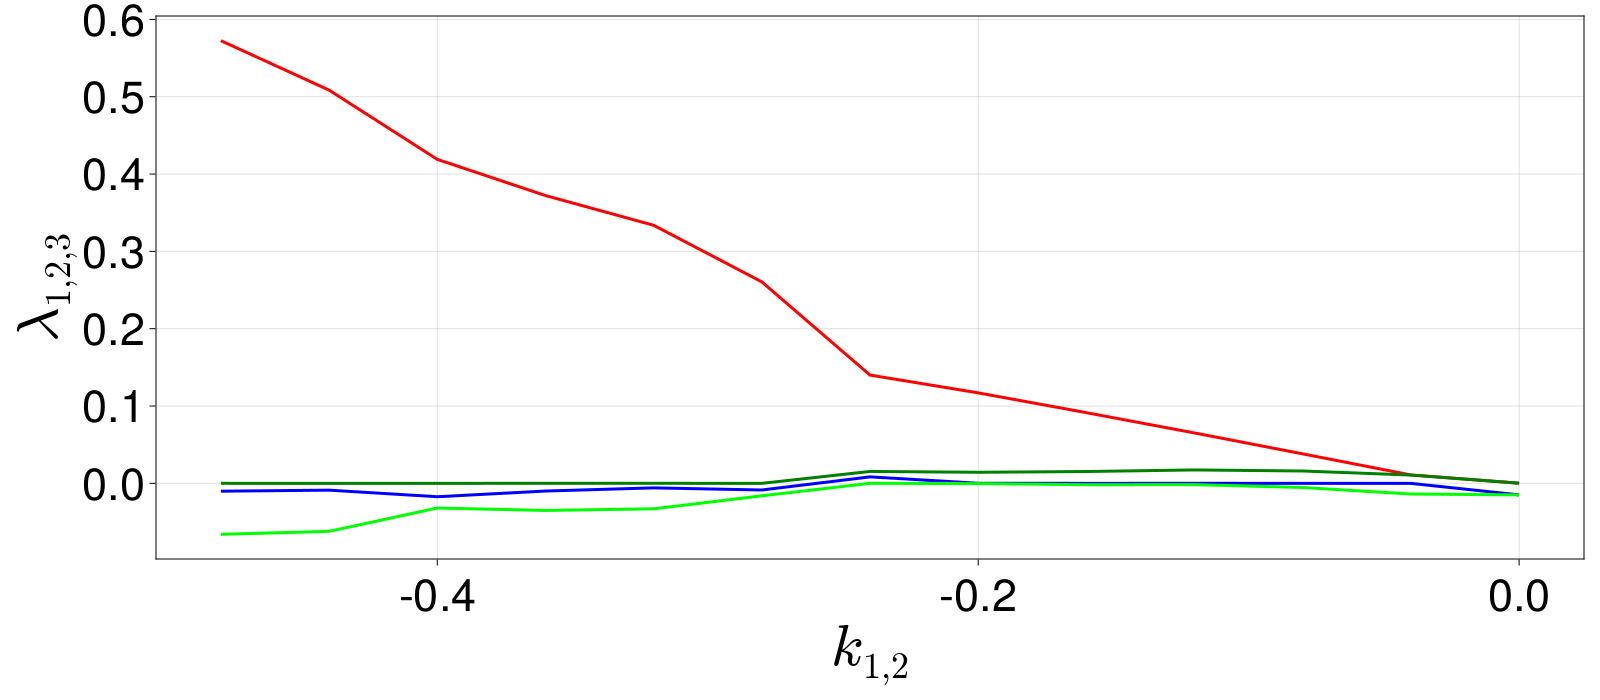

In [33]:
# L2

f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45  )

lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
lines!(ax, k_space, spectrum_array[4, :], linewidth = 3.0, color = "lime")

# save("LE_orbit_full.eps", f)
f